In [5]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn import tree
import pdb
import copy

%matplotlib inline

import tree_structure
import fitting_tools
import evaluations
import optimizations
import gen_data
import objective_builders

# Examining Single-Feature Splitting

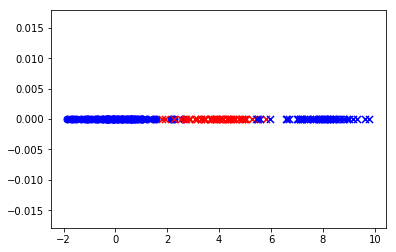

In [263]:
# generate two-gaussian data samples
# class one
n1 = 50
n2 = 50
n3 = 50
X1 = 1.1*np.random.randn(n1)
X2 = np.random.randn(n2) + 4
X3 = np.random.randn(n2) + 8

plt.scatter(X1, np.zeros(n1), marker='o', color='b', s=50)
plt.scatter(X2, np.zeros(n2), marker='x', color='r', s=50)
plt.scatter(X3, np.zeros(n3), marker='x', color='b', s=50)

X = np.concatenate((X1,X3,X2))
labels = np.ones(len(X))
labels[len(X1)+len(X3):] = 2

## Splitting with C4.5

In [260]:
# going through the mid-points one-by-one

# number of classes
c = len(np.unique(labels))

# sorting the data
inds = np.argsort(X)
scores = np.zeros(n1+n2-1)
thetas = np.zeros(n1+n2-1)
eps = 1e-6
for i in range(n1+n2-1):
    thetas[i] = (X[inds[i]] + X[inds[i+1]]) / 2.
    prop = np.zeros((2,c))
    
    # proportions of the classes
    for j in range(c):
        # left side
        prop[0,j] = np.sum(labels[X <= thetas[i]]==j+1) / float(i+1)
        # right side
        prop[1,j] = np.sum(labels[X > thetas[i]]==j+1) / float(n1+n2-(i+1))
        
    # entropy
    entropies = -np.sum((prop+eps) * np.log(prop+eps), axis=1)
    scores[i] = ((i+1)*entropies[0] + (n1+n2-i-1)*entropies[1]) / (n1+n2)

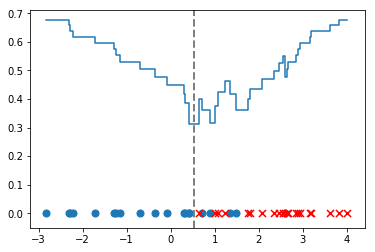

In [292]:
# the result:
best_theta = thetas[np.argmin(scores)]

plt.scatter(X1, np.zeros(n1), marker='o', s=50)
plt.scatter(X2, np.zeros(n2), marker='x', color='r', s=50)

plt.step(X[inds], np.append(scores[0],scores))
plt.axvline(best_theta, linewidth=2, color='gray', linestyle = '--')

## Splitting with Densities

First, let's do a density estimation for each class. Here, we do kernel density estimation (KDE):
$$p(x|y=j) = \frac{1}{n_j}\sum_{y_i=j} k_G(x,x_i)=\frac{1}{n_j\sqrt{2\pi}\sigma}\sum_{y_i=j}e^{-(x-x_i)^2/2\sigma} $$

In [167]:
sigma = .5

# defining KDE function with Gaussian kernel
def class_kernel_1D(dat, x, sigma):
    density_val = 0
    n = dat.shape
    for i in range(len(dat)):
        density_val += np.exp(-(dat[i]-x)**2/(2*sigma)) / (sigma*np.sqrt(2*np.pi))
    return density_val

kernel_c1 = lambda x: class_kernel_1D(X[labels==1], x, sigma)
kernel_c2 = lambda x: class_kernel_1D(X[labels==2], x, sigma)


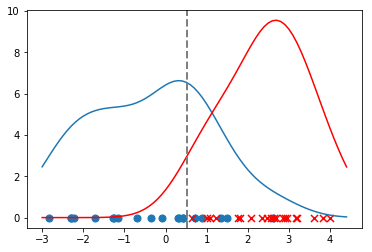

In [171]:
plt.scatter(X1, np.zeros(n1), marker='o', s=50)
plt.scatter(X2, np.zeros(n2), marker='x', color='r', s=50)

eval_points = np.arange(-3,4.5,.1)
plt.plot(eval_points, kernel_c1(eval_points))
plt.plot(eval_points, kernel_c2(eval_points), color='r')

plt.axvline(best_theta, linewidth=2, color='gray', linestyle = '--')

Now, let's form the density-based objective:
$$ -\sum_{j=1}^2 \mathbb{P}(y=j|x\leq \theta) \log\mathbb{P}(y=j|x\leq \theta)$$

where from Bayes rule
$$ \mathbb{P}(y=j|x\leq \theta) = \frac{\mathbb{P}(x\leq\theta|y=j)\cdot\mathbb{P}(y=j)}{\mathbb{P}(x\leq\theta)}.$$

After some simplifications, we get the following objective:
$$ J(\theta) = -\mathbb{E}_y[KL(q(\theta, y), q'(\theta)],$$
where "KL" is the KL-divergence measure, $q_1$ and $q_2$ are two two-element PMFs whose mass probabilities depend on $\theta$:
$$q(\theta,y) = [\mathbb{P}(x\leq\theta|y), \mathbb{P}(x>\theta|y)]$$
$$q'(\theta) = [\mathbb{P}(x\leq\theta), \mathbb{P}(x>\theta)]$$

The objective $J(\theta)$ can also be written as
$$ J(\theta) = \sum_{y=1}^c\pi_j\left[q_1(\theta,j)\log\frac{q'_1(\theta)}{q_1(\theta,j)} + q_2(\theta,j)\log\frac{q'_2(\theta)}{q_2(\theta,j)} \right]$$
where, assuming that we are using Gaussian kernels, we get the following for the CDFs:
$$\pi_j = \frac{n_j}{n},$$
$$ q_1(\theta,y=j) = \mathbb{P}(x\leq\theta|y=j)=\int_{-\infty}^\theta p(x|y=j)dx = \frac{1}{n_j}\sum_{y_i=j}\Phi\left(\frac{\theta-x_i}{\sigma}\right).$$
and
$$ q'_1(\theta) = \mathbb{P}(x\leq\theta)=\int_{-\infty}^\theta p(x)dx = \frac{1}{n}\sum_{i=1}^n\Phi\left(\frac{\theta-x_i}{\sigma}\right).$$

In [247]:
# first computing all the variables present in the equations above

# we can generate q_1 and q'_1 values using the following function
q = lambda theta,dat,sigma: np.sum(norm.cdf((theta - dat)/sigma)) / len(dat)

# the objective function J:
def objective_func(X, labels, sigma, q, theta):
    J = 0
    for j in range(c):
        pi = np.sum(labels==j+1) / float(len(X))
        # different terms
        q_1 = q(theta, X[labels==j+1], sigma)
        qpr_1 = q(theta, X, sigma)
        # adding the corresponding term
        J += pi*(q_1*np.log(qpr_1/q_1) + (1-q_1)*np.log((1-qpr_1) / (1-q_1)))
    
    return J

eval_points = np.arange(-3,4.5,.1)
Js = np.zeros(len(eval_points))
for i in range(len(eval_points)):
    theta = eval_points[i]
    Js[i] = objective_func(X, labels, sigma, q, theta)

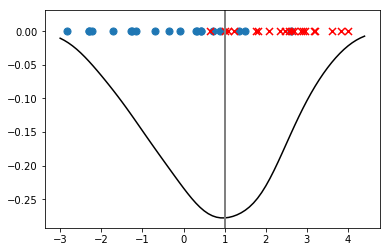

In [251]:
plt.scatter(X1, np.zeros(n1), marker='o', s=50)
plt.scatter(X2, np.zeros(n2), marker='x', color='r', s=50)
plt.plot(eval_points, Js, color='k')

plt.axvline(eval_points[np.argmin(Js)], linewidth=2, color='gray', linestyle = '-')

Comparing the specified threshold with the empirical one:

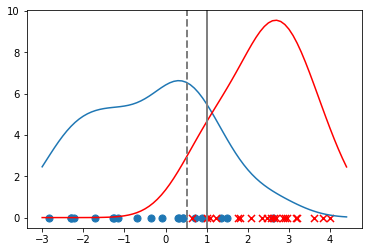

In [250]:
plt.scatter(X1, np.zeros(n1), marker='o', s=50)
plt.scatter(X2, np.zeros(n2), marker='x', color='r', s=50)

eval_points = np.arange(-3,4.5,.1)
plt.plot(eval_points, kernel_c1(eval_points))
plt.plot(eval_points, kernel_c2(eval_points), color='r')

plt.axvline(best_theta, linewidth=2, color='gray', linestyle = '--')
plt.axvline(eval_points[np.argmin(Js)], linewidth=2, color='gray', linestyle = '-')

# Bisection Method for Finding the Minimizer

Above, we exhaustively searched for the minimizer of the impurity measure. Below we try to design a more principled way of locating the minimum of impurity measure using a bisectioning method. For such method, we need to start from an inerval $[a,b]$ which we assume contains a local minimum $\hat{\theta}$. In our application, we can set this interval to be the range that the variable on focus (the feature we are trying to threshold) changes. This is because, we always need to make sure that each of the child nodes get at least one sample. If we set $\theta$ to be too large or too small, then one of the nodes will lose all the samples and that is not desirable.

In [373]:
bisection_min(J_theta, (a,b)), Js.min()

((0.95758309256991891, -0.27791269658769147), -0.27783387789726777)

# Constructing a Full Tree and Pruning it

So far we have the necessary tools for selecting the splitting threshold for any given variable. In this section, we try to get a set of multivariate data samples, and starting from the root, at each node of the tree, we go through all the variables and compute the best threshold. After going through all the variables, we select the one with the smallest minimized objective and its correspondin threshold.

In [270]:
reload(fitting_tools)
reload(tree_structure)
reload(optimizations)
reload(objective_builders)
T = tree_structure.Tree(X, labels, objective_builders.normal_CDF)
T.fit_full_tree()


Comparison with CART algorithm implemented in Scikit-learn library:

In [480]:
sklearn_T = tree.DecisionTreeClassifier()
sklearn_T.fit(np.expand_dims(X, 1), labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

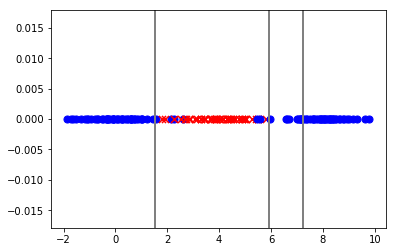

In [265]:
plt.scatter(X1, np.zeros(n1), marker='o', color='b', s=50)
plt.scatter(X2, np.zeros(n2), marker='x', color='r', s=50)
plt.scatter(X3, np.zeros(n2), marker='o', color='b', s=50)
TREE = T#best_T

for i in TREE.leaf_inds:
    parent = TREE.node_dict[str(i)].parent
    plt.axvline(TREE.node_dict[str(parent)].rule['0'], linewidth=2, color='gray', linestyle = '-')
#plt.xlim([-1,2])

In [368]:
reload(evaluations)
X_test = X
s = 1.
a = evaluations.Ling_posterior_estimation(T,X_test, s)
b = T.posteriors_predict(X_test)
b[0].shape, a.shape
print a[:,:5]
print b[0][:,:5]

[[ 0.74280214  0.74280214  0.74280214  0.74280214  0.74280214]
 [ 0.25719786  0.25719786  0.25719786  0.25719786  0.25719786]]
[[ 0.95459648  0.95459648  0.95459648  0.95459648  0.95459648]
 [ 0.04540352  0.04540352  0.04540352  0.04540352  0.04540352]]


In [356]:
np.dot(np.diag(1./(2*np.ones(4))), np.ones((4,2)))

array([[ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5]])

In [481]:
seq, alphas = T.cost_complexity_seq()
seq

0 siblings have been removed from the tree.


[<tree_structure.Tree instance at 0x7fbd1591a8c0>,
 <tree_structure.Tree instance at 0x7fbd19cc55a8>,
 <tree_structure.Tree instance at 0x7fbd0e305ab8>,
 <tree_structure.Tree instance at 0x7fbd15842a70>,
 <tree_structure.Tree instance at 0x7fbd15cf0f38>,
 <tree_structure.Tree instance at 0x7fbd0e305200>,
 <tree_structure.Tree instance at 0x7fbd15bf9758>,
 <tree_structure.Tree instance at 0x7fbd0d76a908>,
 <tree_structure.Tree instance at 0x7fbd15cf01b8>,
 <tree_structure.Tree instance at 0x7fbd0d76a7a0>,
 <tree_structure.Tree instance at 0x7fbd15cf0758>,
 <tree_structure.Tree instance at 0x7fbd15cf0908>]

In [484]:
reload(fitting_tools)

scores, best_T = fitting_tools.CV_prune(T, 5)
print scores

0 siblings have been removed from the tree.
Fitting the full tree for CV 0
0 siblings have been removed from the tree.
Fitting the full tree for CV 1
0 siblings have been removed from the tree.
Fitting the full tree for CV 2
0 siblings have been removed from the tree.
Fitting the full tree for CV 3
0 siblings have been removed from the tree.
Fitting the full tree for CV 4
0 siblings have been removed from the tree.
[ 0.08        0.08        0.08        0.08        0.08        0.08        0.08
  0.08        0.08        0.08        0.08        0.33333333]


Comparing our tree with Scikit-learn's CART tree by generating test samples and calculating their performance's accuracy over them. At this point, we generate the test samples from the same distribution as we generated the training data.

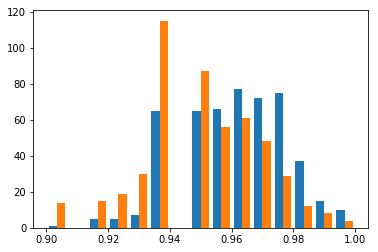

In [494]:
n_exp = 500
accs = np.zeros((2, n_exp))
best_T = seq[-2]
for i in range(n_exp):

    X1 = 1.1*np.random.randn(n1)
    X2 = np.random.randn(n2) + 4
    X3 = np.random.randn(n3) + 8

    test_X = np.concatenate((X1,X3,X2))
    test_labels = np.ones(len(X))
    test_labels[len(X1)+len(X3):] = 2
    
    # KDE-based tree
    probs, preds = best_T.posteriors_predict(test_X)
    class_preds = np.array([best_T.symbols[j] for j in preds])
    accs[0,i] = np.sum(class_preds == test_labels) / float(len(test_labels))
    
    # Original CART tree
    accs[1,i] = np.sum(sklearn_T.predict(np.expand_dims(test_X, 1)) == test_labels) / float(len(test_labels))

#plt.hist(accs[0,:], bins='auto', label='KDE-based Trees')
#plt.hist(accs[1,:], bins='auto', color='red', alpha=.5, label='Original CART trees')
plt.hist(np.transpose(accs), bins='auto')
plt.legend()

In [278]:
probs, preds = best_T.posteriors_predict(test_X)
class_preds = np.array([best_T.symbols[j] for j in preds])
KDE_acc = np.sum(class_preds == test_labels) / float(len(test_labels))
print "KDE-based accuracy: %.3f" % KDE_acc

sklean_acc = np.sum(sklearn_T.predict(np.expand_dims(test_X, 1)) == test_labels) / float(len(test_labels))
print "Original CART accuracy: %.3f" % sklean_acc

KDE-based accuracy: 0.980
Original CART accuracy: 0.960


## Building the objectives:

The ultimate objective $J(\theta)$ depends only on the marginal and class-conditional CDFs, that is $\mathbb{P}(x\leq\theta)$ and $\mathbb{P}(x\leq\theta|y=j)$ (assuming that $x$ is the particular feature component on focus). When using KDE, these CDFs, in turn, depend on the kernel CDF, defined by
$$F_\Lambda(\theta;x_i) = \int_{\infty}^\theta k(x,x_i),$$

where $x_i$ is a fixed point where the kernel is centered on, and $\Lambda$ are the kernel's parameters (e.g., the bandwidth). Recall, $p(x)=\frac{1}{n}\sum_{i=1}^nk(x,x_i)$ and $p(x|y=j)=\frac{1}{n_j}\sum_{y_i=j}k(x,x_i)$. Then,

$$p(x\leq\theta) = \int_{-\infty}^\theta p(x)dx = \frac{1}{n}\sum_{i=1}^n\int_{-\infty}^\theta k(x,x_i)dx = \frac{1}{n}\sum_{i=1}^n F_{\Lambda}(\theta;x_i).$$

Similar equation can be written for the class-conditional case.

# Trying Multivariate data

In [ ]:
# 2D Gaussian data
# generate two-gaussian data samples
# class one
n1 = 500
n2 = 500
n3 = 500
X1 = 1.1*np.random.randn(2, n1)
X2 = np.random.randn(2, n2) + 2.5
X3 = np.random.randn(2, n2) + 5

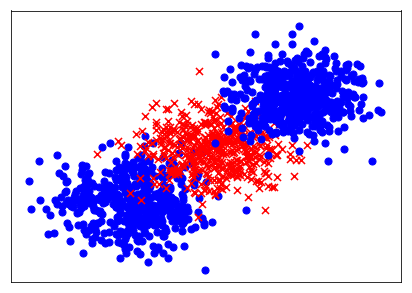

In [774]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.scatter(X1[0,:], X1[1,:], marker='o', color='b', s=50)
ax.scatter(X2[0,:], X2[1,:], marker='x', color='r', s=50)
ax.scatter(X3[0,:], X3[1,:], marker='o', color='b', s=50)

X = np.concatenate((X1,X3,X2), axis=1)
labels = np.ones(n1+n2+n3)
labels[n1+n3:] = 2
ax.set_xticklabels([])
for tic in ax.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
ax.set_yticklabels([])
for tic in ax.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False


In [758]:
reload(fitting_tools)
reload(optimizations)
reload(tree_structure)
reload(objective_builders)

T = tree_structure.Tree(X, labels, objective_builders.normal_CDF)
T.fit_full_tree()

In [759]:
seq, alphas = T.cost_complexity_seq()
scores, best_T = fitting_tools.CV_prune(T, 5)

print scores
print len(T.leaf_inds)
print len(best_T.leaf_inds)

0 siblings have been removed from the tree.
0 siblings have been removed from the tree.
Fitting the full tree for CV 0
0 siblings have been removed from the tree.
Fitting the full tree for CV 1
0 siblings have been removed from the tree.
Fitting the full tree for CV 2
0 siblings have been removed from the tree.
Fitting the full tree for CV 3
0 siblings have been removed from the tree.
Fitting the full tree for CV 4
0 siblings have been removed from the tree.
[ 0.08533333  0.09        0.09        0.09        0.09        0.09        0.09
  0.09        0.09        0.09        0.09        0.09        0.09        0.09
  0.09        0.09        0.09        0.09        0.09        0.09        0.09
  0.09        0.09        0.09        0.09        0.09        0.09        0.09
  0.09        0.09066667  0.09066667  0.09066667  0.09066667  0.09066667
  0.09066667  0.09066667  0.09066667  0.09066667  0.08866667  0.08866667
  0.08866667  0.08866667  0.08866667  0.08866667  0.08866667  0.08866667
  

In [837]:
sklearn_T = tree.DecisionTreeClassifier()
sklearn_T.fit(np.transpose(X), labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [761]:
n_exp = 500
accs_1 = np.zeros((2, n_exp))
best_T = seq[0]
for i in range(n_exp):

    X1 = 1.1*np.random.randn(2, n1)
    X2 = np.random.randn(2, n2) + 2.5
    X3 = np.random.randn(2, n2) + 5

    test_X = np.concatenate((X1,X3,X2), axis=1)
    test_labels = np.ones(n1+n2+n3)
    test_labels[n1+n3:] = 2
    
    # KDE-based tree
    probs, preds = best_T.posteriors_predict(test_X)
    class_preds = np.array([best_T.symbols[j] for j in preds])
    accs_1[0,i] = np.sum(class_preds == test_labels) / float(len(test_labels))
    
    # Original CART tree
    accs_1[1,i] = np.sum(sklearn_T.predict(np.transpose(test_X)) == test_labels) / float(len(test_labels))
    
    if np.remainder(i,10)==0:
        print i

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


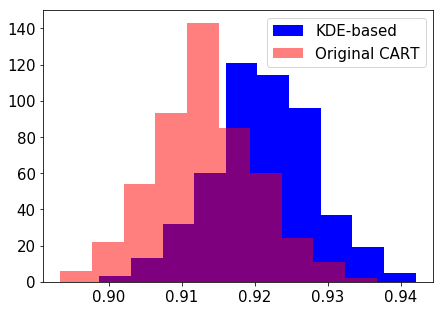

In [780]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)

#plt.hist(np.transpose(accs_1), bins='auto', label=['KDE-based', 'Original CART'])
plt.hist(accs_1[0,:], bins=10, label='KDE-based', color='blue')
plt.hist(accs_1[1,:], bins=10, label='Original CART', color='red', alpha=.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)


In [838]:
sklearn_T.tree_.node_count

249

# More Complicated 2D Data Distributation

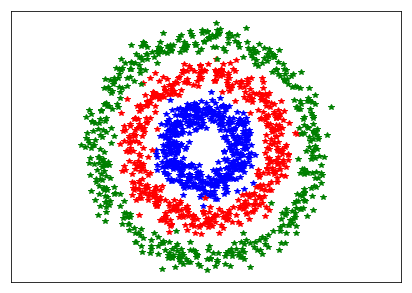

In [140]:
n1, n2, n3 = 500, 500, 500
X_train, Y_train = gen_data.circle_dat(n1, n2, n3, True)

In [832]:
reload(fitting_tools)
reload(optimizations)
reload(tree_structure)
reload(objective_builders)

T2 = tree_structure.Tree(X_train, Y_train, objective_builders.normal_CDF)
T2.fit_full_tree()

In [842]:
seq, alphas = T2.cost_complexity_seq()
scores, best_T2 = fitting_tools.CV_prune(T2, 5)

print scores
print len(T2.node_dict)
print len(best_T2.node_dict)

0 siblings have been removed from the tree.
0 siblings have been removed from the tree.
Fitting the full tree for CV 0
0 siblings have been removed from the tree.
Fitting the full tree for CV 1
0 siblings have been removed from the tree.
Fitting the full tree for CV 2
0 siblings have been removed from the tree.
Fitting the full tree for CV 3
0 siblings have been removed from the tree.
Fitting the full tree for CV 4
0 siblings have been removed from the tree.
[ 0.00266667  0.00266667  0.01333333  0.66666667]
45
41


In [5]:
sklearn_T = tree.DecisionTreeClassifier()
sklearn_T.fit(np.transpose(X_train), Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [847]:
n_exp = 500
accs = np.zeros((2, n_exp))
best_T2 = T2
for i in range(n_exp):

    X_test, Y_test = circle_dat(n1, n2, n3)
    
    # KDE-based tree
    probs, preds = best_T2.posteriors_predict(X_test)
    class_preds = np.array([best_T2.symbols[j] for j in preds])
    accs[0,i] = np.sum(class_preds == Y_test) / float(len(Y_test))
    
    # Original CART tree
    accs[1,i] = np.sum(sklearn_T.predict(np.transpose(X_test)) == Y_test) / float(len(Y_test))
    
    #if np.remainder(i,10)==0:
    #    print i
        

(array([   0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.]),
 <a list of 8 Text yticklabel objects>)

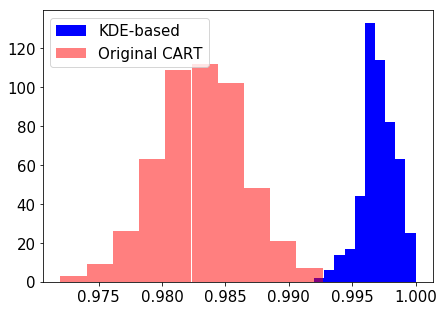

In [848]:
fig = plt.figure(figsize=(7,5))

#plt.hist(np.transpose(accs), bins=20, label=['KDE-based', 'Original CART'])
plt.hist(accs[0,:], bins=10, label='KDE-based', color='blue')
plt.hist(accs[1,:], bins=10, label='Original CART', color='red', alpha=.5)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


In [87]:
# taking all the leaves;
sk_leaf_inds = []
sk_nodes = sklearn_T.tree_.__getstate__()['nodes']
for i in range(len(sk_nodes)):
    if (sk_nodes[i][0]==-1) & (sk_nodes[i][1]==-1):
        sk_leaf_inds += [sk_nodes[i]]
        

sklearn_T.tree_.__getstate__()['nodes']

array([( 1, 44,  0,  2.16184521,  0.66666667, 1500,   1.50000000e+03),
       ( 2,  9,  0, -2.12563658,  0.66045963, 1368,   1.36800000e+03),
       ( 3,  4,  0, -2.20056081,  0.0440952 ,  133,   1.33000000e+02),
       (-1, -1, -2, -2.        ,  0.        ,  124,   1.24000000e+02),
       ( 5,  6,  1, -1.19323874,  0.44444444,    9,   9.00000000e+00),
       (-1, -1, -2, -2.        ,  0.        ,    4,   4.00000000e+00),
       ( 7,  8,  1,  1.22614598,  0.48      ,    5,   5.00000000e+00),
       (-1, -1, -2, -2.        ,  0.        ,    3,   3.00000000e+00),
       (-1, -1, -2, -2.        ,  0.        ,    2,   2.00000000e+00),
       (10, 11,  1, -2.12121248,  0.63700241, 1235,   1.23500000e+03),
       (-1, -1, -2, -2.        ,  0.        ,  115,   1.15000000e+02),
       (12, 35,  1,  2.11879301,  0.59172672, 1120,   1.12000000e+03),
       (13, 18,  1, -1.13611758,  0.506902  , 1000,   1.00000000e+03),
       (14, 17,  0,  1.77665746,  0.04542996,  172,   1.72000000e+02),
      

([], <a list of 0 Text yticklabel objects>)

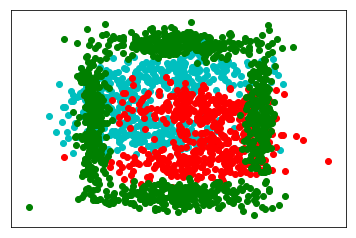

In [216]:
reload(gen_data)

n1, n2 = 500, 500
n3 = 1000
X_train, Y_train, _ = gen_data.generate_class_GMM(n1, n2, n3, True)
plt.xticks([])
plt.yticks([])

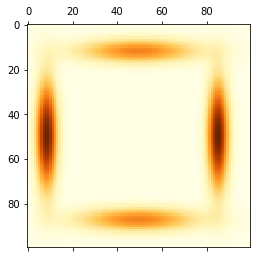

In [446]:
reload(gen_data)
#a = gen_data.eval_GMM(X, specs1)
#a.max()

Xarr = np.linspace(X_train[0,:].min(),X_train[0,:].max(),100)
Yarr = np.linspace(X_train[1,:].min(),X_train[1,:].max(),100)
grid = np.meshgrid(Xarr, Yarr)
Xarr = np.expand_dims(np.reshape(grid[0], 100*100), axis=0)
Yarr = np.expand_dims(np.reshape(grid[1], 100*100), axis=0)
datarr = np.concatenate((Xarr, Yarr), axis=0)
likes = gen_data.eval_GMM(datarr, specs3)

plt.matshow(np.reshape(likes, (100,100)), cmap=plt.cm.YlOrBr)

Training KDE-based and original CART trees based using the generated samples:

In [737]:
reload(tree_structure)
reload(evaluations)

# training original CART tree
sklearn_T = tree.DecisionTreeClassifier()
sklearn_T.fit(np.transpose(X_train), Y_train)

# converting it to KDE-based format
T = tree_structure.convert_SK(sklearn_T, X_train, Y_train, objective_builders.normal_CDF)

# training the tree based on the KDE-based training
KDE_T = tree_structure.Tree(X_train, Y_train, objective_builders.normal_CDF)
KDE_T.fit_full_tree()

In [738]:
len(KDE_T.node_dict)
scores, best_KDE_T = fitting_tools.CV_prune(KDE_T, 5)
scores

0 siblings have been removed from the tree.
Fitting the full tree for CV 0
0 siblings have been removed from the tree.
Fitting the full tree for CV 1
0 siblings have been removed from the tree.
Fitting the full tree for CV 2
0 siblings have been removed from the tree.
Fitting the full tree for CV 3
0 siblings have been removed from the tree.
Fitting the full tree for CV 4
0 siblings have been removed from the tree.


array([ 0.083 ,  0.0795,  0.0795,  0.0795,  0.0795,  0.0795,  0.0795,
        0.0795,  0.0795,  0.0795,  0.0795,  0.0795,  0.0795,  0.0795,
        0.0795,  0.0795,  0.0795,  0.0795,  0.0795,  0.0795,  0.0795,
        0.0795,  0.0795,  0.0795,  0.0795,  0.0795,  0.0795,  0.0795,
        0.0795,  0.0795,  0.0795,  0.5   ])

In [742]:
len(best_KDE_T.node_dict)
len(KDE_T.node_dict)

899

In [743]:
X_test, Y_test, specs_list = gen_data.generate_class_GMM(n1, n2, n3)

posteriors = np.zeros((3, n1+n2+n3))
posteriors[0,:] = gen_data.eval_GMM(X_test, specs_list[0]) * n1 / (n1+n2+n3)
posteriors[1,:] = gen_data.eval_GMM(X_test, specs_list[1]) * n2 / (n1+n2+n3)
posteriors[2,:] = gen_data.eval_GMM(X_test, specs_list[2]) * n3 / (n1+n2+n3)
post_sums = np.repeat(np.expand_dims(np.sum(posteriors,axis=0),axis=0), 3, axis=0)
posteriors /= post_sums

Computing the posterior probabilities for the test samples using both trees:

In [181]:
a = np.zeros((1,3))
np.repeat(a, 2, axis=0)

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [374]:
reload(evaluations)
reload(fitting_tools)
reload(optimizations)
reload(tree_structure)
n_list = [(100,100,200),
          (150,150,300),
          (200,200,400),
          (300,300,500),
          (400,400,600),
          (500,500,1000)]
runs = 20

KDE_loss = (np.zeros((runs, len(n_list))),np.zeros((runs, len(n_list))))
emp_loss = (np.zeros((runs, len(n_list))),np.zeros((runs, len(n_list))))
Lap_loss = (np.zeros((runs, len(n_list))),np.zeros((runs, len(n_list))))
Smyth_loss = (np.zeros((runs, len(n_list))),np.zeros((runs, len(n_list))))
Ling_loss = (np.zeros((runs, len(n_list))),np.zeros((runs, len(n_list))))
TKDE_loss = (np.zeros((runs, len(n_list))),np.zeros((runs, len(n_list))))
total_accs = []

for i in range(runs):
    print "Rinning experiment %d" % (i+1)
    print "===================================================================================="
    KDE_iter, emp_iter, Lap_iter, Smyth_iter, Ling_iter, TKDE_iter, this_accs = evaluations.compare_posterior_estimation(n_list)
    
    KDE_loss[0][i,:] = KDE_iter[0]
    emp_loss[0][i,:] = emp_iter[0]
    Lap_loss[0][i,:] = Lap_iter[0]
    Smyth_loss[0][i,:] = Smyth_iter[0]
    Ling_loss[0][i,:] = Ling_iter[0]
    TKDE_loss[0][i,:] = TKDE_iter[0]
    
    KDE_loss[1][i,:] = KDE_iter[1]
    emp_loss[1][i,:] = emp_iter[1]
    Lap_loss[1][i,:] = Lap_iter[1]
    Smyth_loss[1][i,:] = Smyth_iter[1]
    Ling_loss[1][i,:] = Ling_iter[1]
    TKDE_loss[1][i,:] = TKDE_iter[1]

    total_accs += [this_accs]

Rinning experiment 1
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Rinning experiment 2
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Rinning experiment 3
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
F

Computing the posteriors..
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Rinning experiment 17
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Rinning experiment 18
Fitting CART tree..
Fitting KDE-based tree..
Computing the posteriors..
Fitting CART tree..
Fitting KDE-based tree..
Computing the poster

In [259]:
T.node_dict['0'].parent
list(reversed(T.leaf_inds))

[8, 7, 6, 3, 2]

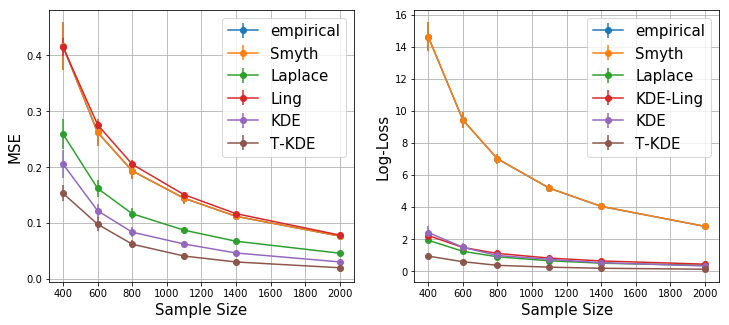

In [375]:

sizes = np.zeros(len(n_list))
for i in range(len(n_list)):
    sizes[i] = sum(n_list[i])

plt.figure(figsize=(12, 5))    
plt.subplot(121)
# MSE
plt.errorbar(sizes, np.mean(emp_loss[0], axis=0), yerr=np.std(emp_loss[0], axis=0), marker='o', label='empirical')
plt.errorbar(sizes, np.mean(Smyth_loss[0], axis=0), yerr=np.std(Smyth_loss[0], axis=0), marker='o', label='Smyth')
plt.errorbar(sizes, np.mean(Lap_loss[0], axis=0), yerr=np.std(Lap_loss[0], axis=0), marker='o', label='Laplace')
plt.errorbar(sizes, np.mean(Ling_loss[0], axis=0), yerr=np.std(Ling_loss[0], axis=0), marker='o', label='Ling')
plt.errorbar(sizes, np.mean(KDE_loss[0], axis=0), yerr=np.std(KDE_loss[0], axis=0), marker='o', label='KDE')
plt.errorbar(sizes, np.mean(TKDE_loss[0], axis=0), yerr=np.std(TKDE_loss[0], axis=0), marker='o', label='T-KDE')
plt.legend(fontsize=15)
plt.xlabel('Sample Size', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.grid()

# Log-Loss
plt.subplot(122)
plt.errorbar(sizes, np.mean(emp_loss[1], axis=0), yerr=np.std(emp_loss[1], axis=0), marker='o', label='empirical')
plt.errorbar(sizes, np.mean(Smyth_loss[1], axis=0), yerr=np.std(Smyth_loss[1], axis=0), marker='o', label='Smyth')
plt.errorbar(sizes, np.mean(Lap_loss[1], axis=0), yerr=np.std(Lap_loss[1], axis=0), marker='o', label='Laplace')
plt.errorbar(sizes, np.mean(Ling_loss[1], axis=0), yerr=np.std(Ling_loss[1], axis=0), marker='o', label='KDE-Ling')
plt.errorbar(sizes, np.mean(KDE_loss[1], axis=0), yerr=np.std(KDE_loss[1], axis=0), marker='o', label='KDE')
plt.errorbar(sizes, np.mean(TKDE_loss[1], axis=0), yerr=np.std(TKDE_loss[1], axis=0), marker='o', label='T-KDE')
plt.legend(fontsize=15)
plt.xlabel('Sample Size', fontsize=15)
plt.ylabel('Log-Loss', fontsize=15)
plt.grid()

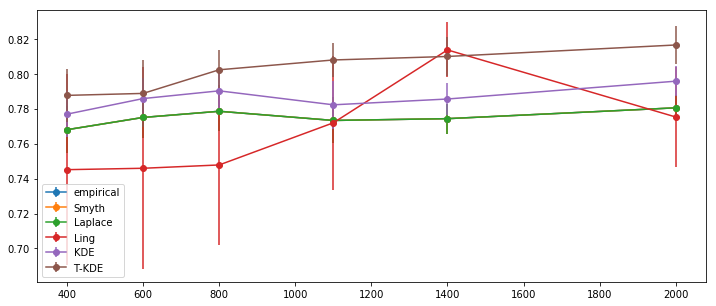

In [376]:
plt.figure(figsize=(12, 5))
order = [1, 3, 2, 4, 0,5]
order_name = ["empirical", "Smyth", "Laplace", "Ling", "KDE", "T-KDE"]
for i in range(6):
    accs = np.zeros((runs,len(sizes)))
    for t in range(runs):
        accs[t,:] = total_accs[t][order[i],:]
    plt.errorbar(sizes, np.mean(accs, axis=0), yerr=np.std(accs, axis=0), marker='o', label=order_name[i])
plt.legend()

In [208]:
i=3
accs = np.zeros((runs,len(sizes)))
for t in range(runs):
    accs[t,:] = total_accs[t][order[i],:]
accs

array([[ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5]])